<a href="https://colab.research.google.com/github/adsamaz/Chattbot/blob/master/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = df_.append({
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent[0:])
        }, ignore_index=True)
    return data



In [0]:
# If this is the primary file that is executed (ie not an import of another file)
if __name__ == "__main__":
    # get data, pre-process and split
    data = pd.read_csv("https://raw.githubusercontent.com/adsamaz/Chattbot/master/ANN_project_files/amazon_cells_labelled.txt?token=AH6YBL7A3NJ4RA5LTSEYWC254TOFO", delimiter='\t', header=None)
    data.columns = ['Sentence', 'Class']
    data['index'] = data.index                                          # add new column index
    columns = ['index', 'Class', 'Sentence']
    data = preprocess_pandas(data, columns)                             # pre-process
    training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
        data['Sentence'].values.astype('U'),
        data['Class'].values.astype('int32'),
        test_size=0.10,
        random_state=0,
        shuffle=True
    )

    # vectorize data using TFIDF and transform for PyTorch for scalability
    word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
    training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
    training_data = training_data.todense()                             # convert to dense matrix for Pytorch
    vocab_size = len(word_vectorizer.vocabulary_)
    validation_data = word_vectorizer.transform(validation_data)
    validation_data = validation_data.todense()
    train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
    train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
    validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
    validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()


In [15]:
# This code initializes the neural network
network = nn.Sequential(
    nn.Linear(7305, 500), nn.ReLU(), nn.Linear(500, 2)
)

# Initialize the optimizer
optimizer = optim.Adam(network.parameters(), lr=0.01)

# Initialize the loss function
loss_function = nn.MSELoss()

# An Embedding layer used for turning int into one-hot (0 -> [1,0,0,0,0,0,0,0,0,0], 5 -> [0,0,0,0,0,1,0,0,0,0])
to_onehot = nn.Embedding(2, 2) 
to_onehot.weight.data = torch.eye(2)

to_onehot(train_y_tensor)

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]], grad_fn=<EmbeddingBackward>)

Epoch 100 - Loss: 1.7541494798933854e-06

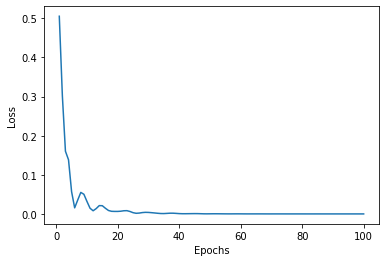

"plt.plot(range(0, epochs+1), accuracy)\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.show()"

In [16]:
# Decide the number of epochs to train for (one epoch is one complete run-through of the data)
epochs = 100


# Create a list to keep track of how the loss changes
losses = []
accuracy = [0]
# For each epoch
for epoch in range(epochs):

    # A variable for containing the sum of all batch losses for this epoch
    epoch_loss = 0

    # For each batch
    #for batch_nr, (images, labels) in enumerate(train_loader):

    # Extract the labels and turn them into one-hot representation (note: not all loss functions needs this)
    labels = to_onehot(train_y_tensor)

    # Predict for each digit in the batch whatclass they belong to
    prediction = network(train_x_tensor)

    # Calculate the loss of the prediction by comparing to the expected output
    loss = loss_function(prediction, labels)

    # Backpropogate the loss through the network to find the gradients of all parameters
    loss.backward()

    # Update the parameters along their gradients
    optimizer.step()

    # Clear stored gradient values
    optimizer.zero_grad()

    # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
    epoch_loss += loss.item()

    # Print the epoch, batch, and loss
    print(
        '\rEpoch {} - Loss: {}'.format(
            epoch+1, loss
        ),
        end=''
    )

    # Append the epoch loss to the list of losses
    #accu = validate_on_images(iter(validation_loader))
    #accuracy.append(accu)
    #print(" Accuracy:",accu)
    losses.append(epoch_loss)

# Plot the training loss per epoch
plt.plot(range(1, epochs+1), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

"""plt.plot(range(0, epochs+1), accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()"""

# Have the trained network predict on some images
#predict_on_images(iterator=iter(train_loader), images_to_show=10)

In [14]:
prediction.shape

torch.Size([900, 2])